# Create, evaluate, and score a machine fault detection model

## Introduction

In this notebook, you learn the data science workflow with an end-to-end example. The scenario is to use machine learning to have a more systematic approach to fault diagnosis in order to proactively identify issues and take actions before a machine's actual failure. In this scenario, the aim is to predict whether a machine would experience a failure based on features such as process temperature, rotational speed, etc. 

The summary of main steps you take in this notebook are:

1. Install custom libraries
2. Load the data
3. Understand and process the data through exploratory data analysis
4. Train machine learning models using Scikit-Learn and XGBoost. Track experiments using MLflow and Fabric Autologging feature 
5. Score the trained model using Fabric PREDICT feature, save the best model, and load it for predictions
6. Demonstrate the model performance via visualizations in Power BI

## Prerequisites
- [Add a lakehouse](https://aka.ms/fabric/addlakehouse) to this notebook. You will be downloading data from a public blob, then storing the data in the lakehouse. 

## Step 1: Install custom libraries

When developing a machine learning model or doing ad-hoc data analysis, you may need to quickly install a custom library (e.g., `imblearn` in this notebook) for your Apache Spark session. To install a library, you have two choices. 

1. You can use the in-line installation capabilities (for example, `%pip`, `%conda`, etc.) to quickly get started with new libraries. Note that installing this only installs the custom libraries in the current notebook and not in the workspace.

```python
# Use pip to install libraries
%pip install <library name>

# Use conda to install libraries
%conda install <library name>
 
```
2. Alternatively, you can create a Fabric environment, install libraries from public sources or upload custom libraries to it, and then your workspace admin can attach the environment as the default for the workspace. All the libraries in the environment will then become available for use in any notebooks and Spark job definitions in the workspace. For more information on environments, see [create, configure, and use an environment in Microsoft Fabric](https://aka.ms/fabric/create-environment).

In this notebook, you need to install Imbalanced-learn (imported as `imblearn`) which is a library for synthetic minority oversampling technique (SMOTE). You will proceed with `%pip install` as was discussed in the first approach. Note that the PySpark kernel will be restarted after `%pip install`, thus you need to install the library before you run any other cells.

In [ ]:
# Using pip to install imblearn
%pip install imblearn

StatementMeta(, 94ef0508-639f-4da3-a5fe-32b612c119d8, 39, Finished, Available)


[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: /nfs4/pyenv-59ec15df-9c44-4aad-96b6-cafc78b122ae/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Step 2: Load the data

### Dataset

The dataset simulates logging of a manufacturing machine's parameters as a function of time, which is common in industrial settings. It consists of 10,000 data points stored as rows with features as columns. The features include:
1. A Unique Identifier (UID) ranging from 1 to 10000. 
2. Product ID, consisting of a letter L, M, or H, indicating the product quality variant, and a variant-specific serial number. Low, medium, and high-quality variants make up 60%, 30%, and 10% of all products, respectively.
3. Air temperature in Kelvin.
4. Process Temperature in Kelvin. 
5. Rotational Speed in rpm.
6. Torque in Nm.
7. Tool Wear in minutes. The quality variants H, M, and L add 5, 3, and 2 minutes of tool wear to the used tool in the process, respectively.
8. Machine Failure Label, indicating whether the machine has failed in this particular data point for any of the following five independent failure modes:
<br/><br/>
    - Tool Wear Failure (TWF): the tool is replaced or fails at a randomly selected tool wear time between 200 and 240 minutes.
    - Heat Dissipation Failure (HDF): heat dissipation causes a process failure if the difference between air and process temperature is below 8.6 K and the tool's rotational speed is below 1380 rpm.
    - Power Failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. The process fails if this power is below 3500 W or above 9000 W.
    - OverStrain Failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain.
    - Random Failures (RNF): each process has a chance of 0.1% to fail regardless of its process parameters.

> [!NOTE]
> If at least one of the above failure modes is true, the process fails, and the `machine failure` label is set to 1. It's therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail.

### Download dataset and upload to lakehouse

Connect to Azure Open Datasets Container and load the Predictive Maintenance dataset. This code downloads a publicly available version of the dataset and then stores it in a Fabric lakehouse.

> [!IMPORTANT]
> [Add a lakehouse](https://aka.ms/fabric/addlakehouse) to the notebook before running it. **Failure to do so results in an error.**

In [ ]:
# Download demo data files into lakehouse if not exist
import os, requests
DATA_FOLDER = "Files/predictive_maintenance/"  # Folder containing the dataset
DATA_FILE = "predictive_maintenance.csv"  # Data file name
remote_url = "https://synapseaisolutionsa.blob.core.windows.net/public/MachineFaultDetection"
file_list = ["predictive_maintenance.csv"]
download_path = f"/lakehouse/default/{DATA_FOLDER}/raw"

if not os.path.exists("/lakehouse/default"):
    raise FileNotFoundError(
        "Default lakehouse not found, please add a lakehouse and restart the session."
    )
os.makedirs(download_path, exist_ok=True)
for fname in file_list:
    if not os.path.exists(f"{download_path}/{fname}"):
        r = requests.get(f"{remote_url}/{fname}", timeout=30)
        with open(f"{download_path}/{fname}", "wb") as f:
            f.write(r.content)
print("Downloaded demo data files into lakehouse.")

StatementMeta(, 94ef0508-639f-4da3-a5fe-32b612c119d8, 41, Finished, Available)

Downloaded demo data files into lakehouse.


Start recording the time it takes to run this notebook.

In [ ]:
# Record the notebook running time
import time

ts = time.time()

StatementMeta(, 94ef0508-639f-4da3-a5fe-32b612c119d8, 42, Finished, Available)

Once the dataset is downloaded into the lakehouse, you can load it as a spark DataFrame. 

In [ ]:
df = (
    spark.read.option("header", True)
    .option("inferSchema", True)
    .csv(f"{DATA_FOLDER}raw/{DATA_FILE}")
    .cache()
)
df.show(5)

StatementMeta(, 94ef0508-639f-4da3-a5fe-32b612c119d8, 43, Finished, Available)

+---+----------+----+-------------------+-----------------------+----------------------+-----------+---------------+------+------------+
|UDI|Product ID|Type|Air temperature [K]|Process temperature [K]|Rotational speed [rpm]|Torque [Nm]|Tool wear [min]|Target|Failure Type|
+---+----------+----+-------------------+-----------------------+----------------------+-----------+---------------+------+------------+
|  1|    M14860|   M|              298.1|                  308.6|                  1551|       42.8|              0|     0|  No Failure|
|  2|    L47181|   L|              298.2|                  308.7|                  1408|       46.3|              3|     0|  No Failure|
|  3|    L47182|   L|              298.1|                  308.5|                  1498|       49.4|              5|     0|  No Failure|
|  4|    L47183|   L|              298.2|                  308.6|                  1433|       39.5|              7|     0|  No Failure|
|  5|    L47184|   L|              298.2|

### Write Spark DataFrame to lakehouse delta table

Format the data (for example, replace space with underscore) to facilitate spark operations in subsequent steps. 

In [ ]:
# Replace space in column name with underscore to avoid invalid character while saving 
df = df.toDF(*(c.replace(' ', '_') for c in df.columns))
table_name = "predictive_maintenance_data"
df.show(5)


StatementMeta(, 94ef0508-639f-4da3-a5fe-32b612c119d8, 44, Finished, Available)

+---+----------+----+-------------------+-----------------------+----------------------+-----------+---------------+------+------------+
|UDI|Product_ID|Type|Air_temperature_[K]|Process_temperature_[K]|Rotational_speed_[rpm]|Torque_[Nm]|Tool_wear_[min]|Target|Failure_Type|
+---+----------+----+-------------------+-----------------------+----------------------+-----------+---------------+------+------------+
|  1|    M14860|   M|              298.1|                  308.6|                  1551|       42.8|              0|     0|  No Failure|
|  2|    L47181|   L|              298.2|                  308.7|                  1408|       46.3|              3|     0|  No Failure|
|  3|    L47182|   L|              298.1|                  308.5|                  1498|       49.4|              5|     0|  No Failure|
|  4|    L47183|   L|              298.2|                  308.6|                  1433|       39.5|              7|     0|  No Failure|
|  5|    L47184|   L|              298.2|

In [ ]:
# Save data with processed columns to the lakehouse 
df.write.mode("overwrite").format("delta").save(f"Tables/{table_name}")
print(f"Spark dataframe saved to delta table: {table_name}")

StatementMeta(, 94ef0508-639f-4da3-a5fe-32b612c119d8, 45, Finished, Available)

Spark dataframe saved to delta table: predictive_maintenance_data


## Step 3: Preprocess data and perform exploratory data analysis 

Convert spark DataFrame to pandas dataFrame to use pandas compatible popular plotting libraries. Note that for large datasets, you may need to load a portion of the dataset. 

In [ ]:
data = spark.read.format("delta").load("Tables/predictive_maintenance_data")
SEED = 1234
df = data.toPandas()
df.drop(['UDI', 'Product_ID'],axis=1,inplace=True)
# Rename the Target column to IsFail
df = df.rename(columns = {'Target': "IsFail"})
df.info()

StatementMeta(, 94ef0508-639f-4da3-a5fe-32b612c119d8, 46, Finished, Available)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     10000 non-null  object 
 1   Air_temperature_[K]      10000 non-null  float64
 2   Process_temperature_[K]  10000 non-null  float64
 3   Rotational_speed_[rpm]   10000 non-null  int32  
 4   Torque_[Nm]              10000 non-null  float64
 5   Tool_wear_[min]          10000 non-null  int32  
 6   IsFail                   10000 non-null  int32  
 7   Failure_Type             10000 non-null  object 
dtypes: float64(3), int32(3), object(2)
memory usage: 507.9+ KB


Convert specific columns of the dataset to floats and integer types and map strings such as [`L`, `M`, `H`] to numerical values [0, 1, 2].

In [ ]:
# Convert temperature, rotational speed, torque, and tool wear columns to float
df['Air_temperature_[K]'] = df['Air_temperature_[K]'].astype(float)
df['Process_temperature_[K]'] = df['Process_temperature_[K]'].astype(float)
df['Rotational_speed_[rpm]'] = df['Rotational_speed_[rpm]'].astype(float)
df['Torque_[Nm]'] = df['Torque_[Nm]'].astype(float)
df['Tool_wear_[min]'] = df['Tool_wear_[min]'].astype(float)

# Convert the 'Target' column to integer 
df['IsFail'] = df['IsFail'].astype(int)
# Map 'L', 'M', 'H' to numerical values 
df['Type'] = df['Type'].map({'L': 0, 'M': 1, 'H': 2})

StatementMeta(, 94ef0508-639f-4da3-a5fe-32b612c119d8, 47, Finished, Available)

### Explore data through visualizations

StatementMeta(, 94ef0508-639f-4da3-a5fe-32b612c119d8, 48, Finished, Available)

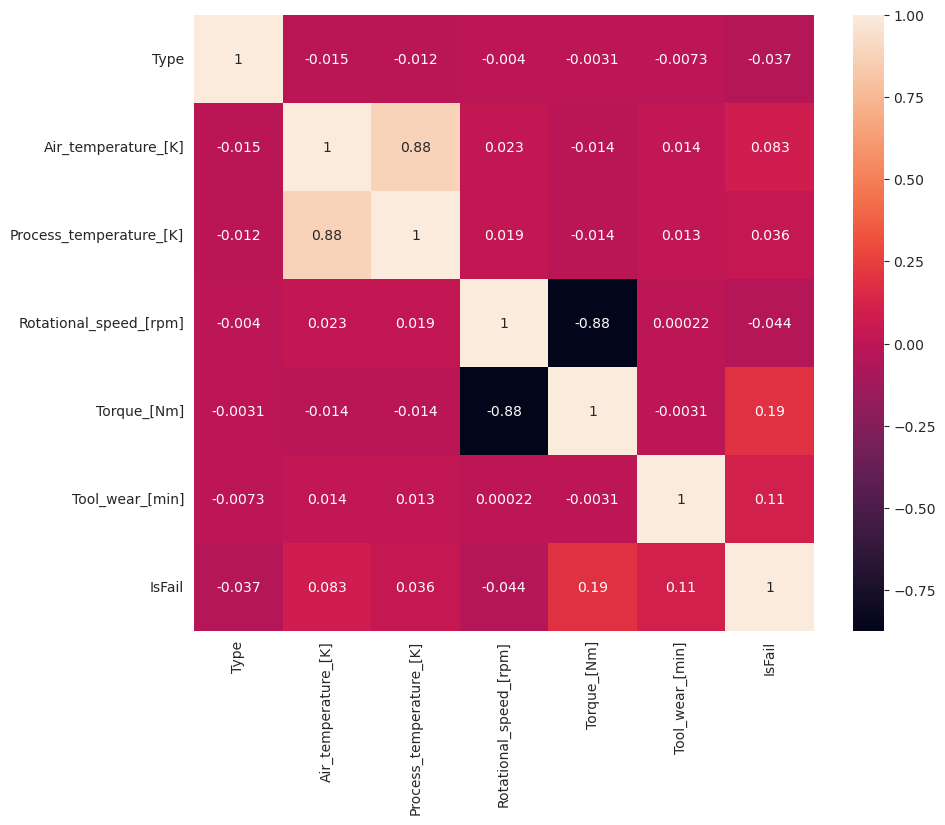

In [ ]:
# Import packages and set plotting style
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
sns.set_style('darkgrid')

# Create the correlation matrix
corr_matrix = df.corr(numeric_only=True)

# Plot a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True)
plt.show()

The correlation matrix shows that `Air_temperature`, `Process_temperature`, `Rotational_speed`, `Torque`, and `Tool_wear` have the highest correlation with the `IsFail` variable.

StatementMeta(, 94ef0508-639f-4da3-a5fe-32b612c119d8, 49, Finished, Available)

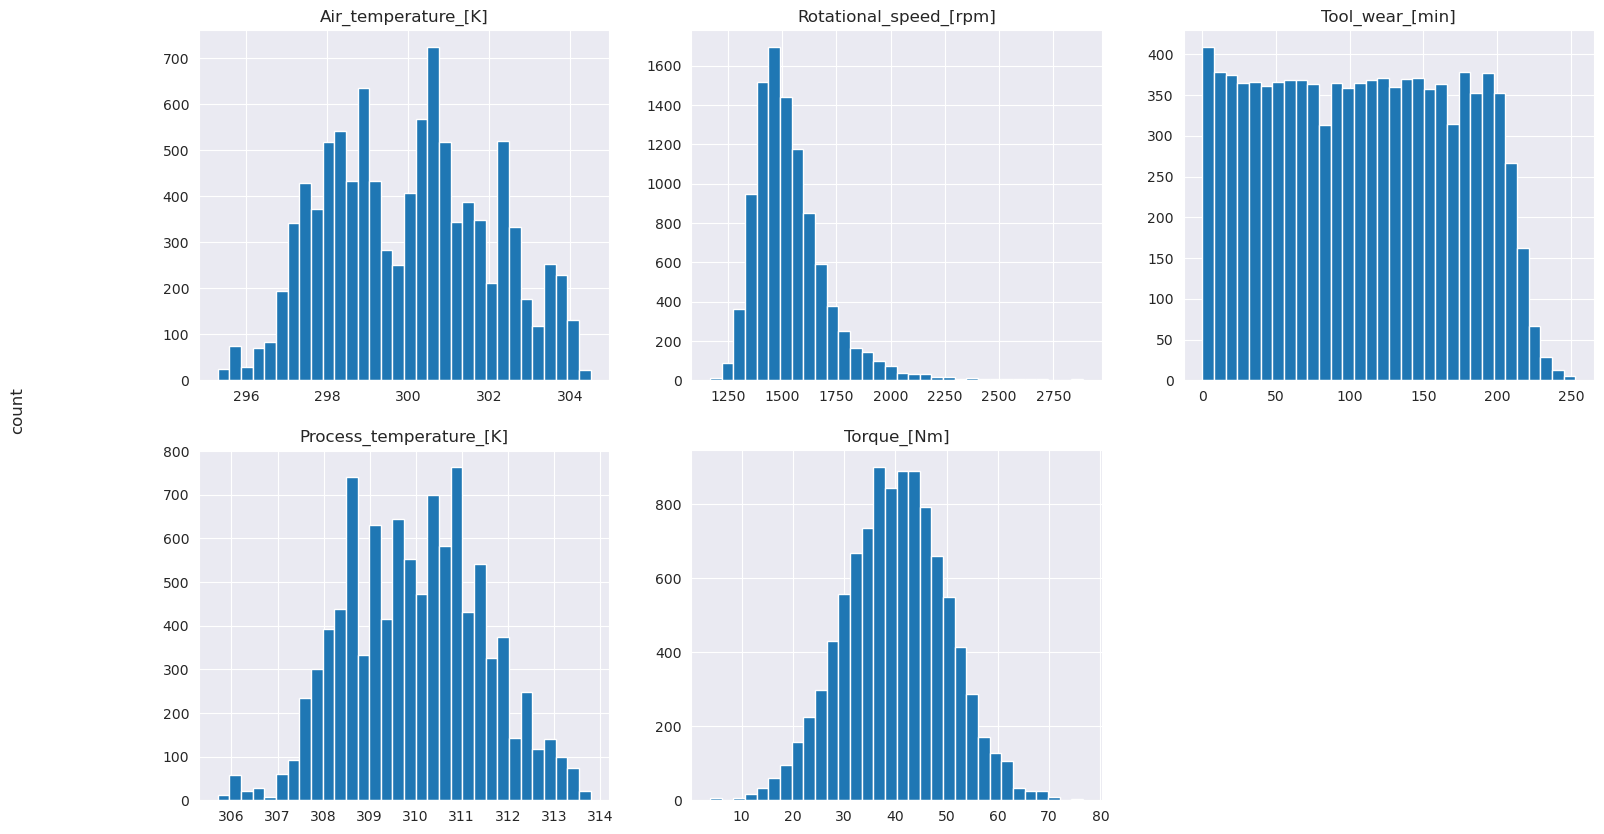

In [ ]:
# Plot histograms of select features
fig, axes = plt.subplots(2, 3, figsize=(18,10))
columns = ['Air_temperature_[K]', 'Process_temperature_[K]', 'Rotational_speed_[rpm]', 'Torque_[Nm]', 'Tool_wear_[min]']
data=df.copy()
for ind, item in enumerate (columns):
    column = columns[ind]
    df_column = data[column]
    df_column.hist(ax = axes[ind%2][ind//2], bins=32).set_title(item)
fig.supylabel('count')
fig.subplots_adjust(hspace=0.2)
fig.delaxes(axes[1,2])

As can be seen from the plotted graphs, the `Air_temperature`, `Process_temperature`, `Rotational_speed`, `Torque`, and `Tool_wear` variables aren't sparse and appear to have good continuity in the feature space. These plots confirm that training a machine learning model on this dataset is likely to produce results that are reliable and can be generalized to new dataset.    

### Inspect the target variable for class imbalance 

Count the number of samples for failed and unfailed machines and inspect the data balance for each class (`IsFail`=0, `IsFail`=1). 

StatementMeta(, 94ef0508-639f-4da3-a5fe-32b612c119d8, 50, Finished, Available)

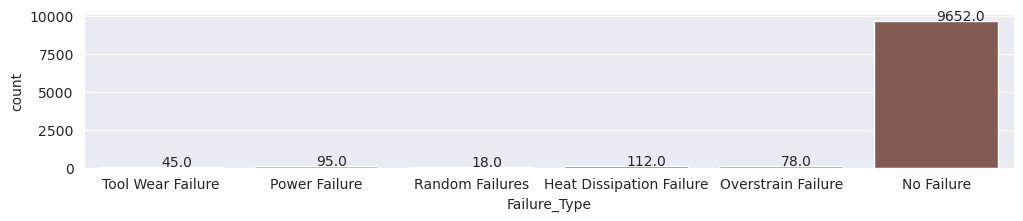

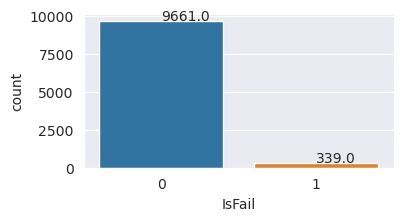

In [ ]:
# Plot the counts for no-failure and each failure types
plt.figure(figsize=(12, 2))
ax = sns.countplot(x='Failure_Type', data=df)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x()+0.4, p.get_height()+50))

plt.show()

# Plot the counts for no failure versus sum of all failure types
plt.figure(figsize=(4, 2))
ax = sns.countplot(x='IsFail', data=df)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x()+0.4, p.get_height()+50))

plt.show()


The plots indicate that the no failure class (shown as `IsFail=0` in the second plot) constitutes most of the samples. Use an oversampling technique to create a more balanced training dataset.

In [ ]:
# Separate features and target
features = df[['Type', 'Air_temperature_[K]', 'Process_temperature_[K]', 'Rotational_speed_[rpm]', 'Torque_[Nm]', 'Tool_wear_[min]']]
labels = df['IsFail']

StatementMeta(, 94ef0508-639f-4da3-a5fe-32b612c119d8, 51, Finished, Available)

In [ ]:
# Split the dataset into the train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

StatementMeta(, 94ef0508-639f-4da3-a5fe-32b612c119d8, 52, Finished, Available)

In [ ]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
# Save test data to lakehouse for use in future
table_name = "predictive_maintenance_test_data"
df_test_X = spark.createDataFrame(X_test)
df_test_X.write.mode("overwrite").format("delta").save(f"Tables/{table_name}")
print(f"Spark dataframe saved to delta table: {table_name}")

StatementMeta(, 94ef0508-639f-4da3-a5fe-32b612c119d8, 53, Finished, Available)

Spark dataframe saved to delta table: predictive_maintenance_test_data


### Oversample to balance classes the training dataset

The previous analysis showed that the dataset is highly imbalanced. The problem with imbalanced classification is that there are too few examples of the minority class for a model to effectively learn the decision boundary. 

Use [<span style="color:blue">SMOTE</span>](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html), which is a widely used oversampling technique that generates synthetic examples. It generates examples for the minority class based on the distances between data points using Euclidean distance. This method is different from random oversampling as it creates new examples that aren't just duplicates of the minority class, making it a more effective technique for imbalanced datasets.

Note that you will be able to access SMOTE using the `imblearn` library that you installed in Step 1.


In [ ]:
# Disable MLflow autologging to avoid tracking the SMOTE fitting
import mlflow

mlflow.autolog(disable=True)

StatementMeta(, 94ef0508-639f-4da3-a5fe-32b612c119d8, 54, Finished, Available)

In [ ]:
from imblearn.combine import SMOTETomek
smt = SMOTETomek(random_state=SEED)
X_train_res, y_train_res = smt.fit_resample(X_train, y_train)

StatementMeta(, 94ef0508-639f-4da3-a5fe-32b612c119d8, 55, Finished, Available)

StatementMeta(, 94ef0508-639f-4da3-a5fe-32b612c119d8, 56, Finished, Available)

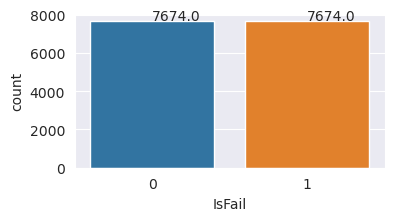

In [ ]:
# Plot the counts for both classes
plt.figure(figsize=(4, 2))
ax = sns.countplot(x='IsFail', data=pd.DataFrame({'IsFail': y_train_res.values}))
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x()+0.4, p.get_height()+50))

plt.show()

You have successfully balanced the dataset and can move to model training.

## Step 4: Train and evaluate the model

[MLflow](https://aka.ms/fabric-autologging) is used to register models, train and compare various models, and pick the best model for prediction purpose. For model training, you use the following 3 models:

1. Random forest classifier
2. Logistic regression classifier 
3. XGBoost classifier 

### Train a Random Forest classifier

In [ ]:
import numpy as np 
from sklearn.ensemble import RandomForestClassifier
from mlflow.models.signature import infer_signature
from sklearn.metrics import f1_score, accuracy_score, recall_score

mlflow.set_experiment("Machine_Failure_Classification")
mlflow.autolog(exclusive=False) # Override the pre-configured autologging behavior

with mlflow.start_run() as run:
    rfc_id = run.info.run_id
    print(f"run_id {rfc_id}, status: {run.info.status}")
    rfc = RandomForestClassifier(max_depth=5, n_estimators=50)
    rfc.fit(X_train_res, y_train_res) 
    signature = infer_signature(X_train_res, y_train_res)

    mlflow.sklearn.log_model(
        rfc,
        "machine_failure_model_rf",
        signature=signature,
        registered_model_name="machine_failure_model_rf"
    ) 

    y_pred_train = rfc.predict(X_train)
    # Calculate the classification metrics for test data
    f1_train = f1_score(y_train, y_pred_train, average='weighted')
    accuracy_train = accuracy_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train, average='weighted')

    # Log the classification metrics to MLflow
    mlflow.log_metric("f1_score_train", f1_train)
    mlflow.log_metric("accuracy_train", accuracy_train)
    mlflow.log_metric("recall_train", recall_train)

    # Print the run ID and the classification metrics
    print("F1 score_train:", f1_train)
    print("Accuracy_train:", accuracy_train)
    print("Recall_train:", recall_train)    

    y_pred_test = rfc.predict(X_test)
    # Calculate the classification metrics for test data
    f1_test = f1_score(y_test, y_pred_test, average='weighted')
    accuracy_test = accuracy_score(y_test, y_pred_test)
    recall_test = recall_score(y_test, y_pred_test, average='weighted')

    # Log the classification metrics to MLflow
    mlflow.log_metric("f1_score_test", f1_test)
    mlflow.log_metric("accuracy_test", accuracy_test)
    mlflow.log_metric("recall_test", recall_test)

    # Print the classification metrics
    print("F1 score_test:", f1_test)
    print("Accuracy_test:", accuracy_test)
    print("Recall_test:", recall_test)

StatementMeta(, 94ef0508-639f-4da3-a5fe-32b612c119d8, 57, Finished, Available)

2023/09/08 22:37:27 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/09/08 22:37:27 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2023/09/08 22:37:27 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.
Successfully registered model 'machine_failure_model_rf'.
2023/09/08 22:37:38 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: machine_failure_model_rf, version 2
Created version '2' of model 'machine_failure_model_rf'.


run_id 807065b0-81e4-4b9e-931b-de6306c73c4a, status: RUNNING
F1 score_train: 0.9395517666293492
Accuracy_train: 0.91975
Recall_train: 0.91975
F1 score_test: 0.9271343476408416
Accuracy_test: 0.903
Recall_test: 0.903


As you can see, both train and test dataset yield F1 score, accuracy and recall of approximately 0.9 using Random Forest classifier. 

### Train a Logistic Regression classifier

In [ ]:
from sklearn.linear_model import LogisticRegression

with mlflow.start_run() as run:
    lr_id = run.info.run_id
    print(f"run_id {lr_id}, status: {run.info.status}")
    lr = LogisticRegression(random_state=42)
    lr.fit(X_train_res, y_train_res)
    signature = infer_signature(X_train_res, y_train_res)
  
    mlflow.sklearn.log_model(
        lr,
        "machine_failure_model_lr",
        signature=signature,
        registered_model_name="machine_failure_model_lr"
    ) 

    y_pred_train = lr.predict(X_train)
    # Calculate the classification metrics for train data
    f1_train = f1_score(y_train, y_pred_train, average='weighted')
    accuracy_train = accuracy_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train, average='weighted')

    # Log the classification metrics to MLflow
    mlflow.log_metric("f1_score_train", f1_train)
    mlflow.log_metric("accuracy_train", accuracy_train)
    mlflow.log_metric("recall_train", recall_train)

    # Print the run ID and the classification metrics
    print("F1 score_train:", f1_train)
    print("Accuracy_train:", accuracy_train)
    print("Recall_train:", recall_train)    

    y_pred_test = lr.predict(X_test)
    # Calculate the classification metrics for test data
    f1_test = f1_score(y_test, y_pred_test, average='weighted')
    accuracy_test = accuracy_score(y_test, y_pred_test)
    recall_test = recall_score(y_test, y_pred_test, average='weighted')

    # Log the classification metrics to MLflow
    mlflow.log_metric("f1_score_test", f1_test)
    mlflow.log_metric("accuracy_test", accuracy_test)
    mlflow.log_metric("recall_test", recall_test)


StatementMeta(, 94ef0508-639f-4da3-a5fe-32b612c119d8, 58, Finished, Available)

run_id 796823eb-6b88-41a1-a66e-adddfb189127, status: RUNNING
F1 score_train: 0.8892891488665593
Accuracy_train: 0.8415
Recall_train: 0.8415


Successfully registered model 'machine_failure_model_lr'.
2023/09/08 22:37:52 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: machine_failure_model_lr, version 2
Created version '2' of model 'machine_failure_model_lr'.


### Train an XGBoost classifier

In [ ]:
from xgboost import XGBClassifier

with mlflow.start_run() as run:
    xgb = XGBClassifier()
    xgb_id = run.info.run_id 
    print(f"run_id {xgb_id}, status: {run.info.status}")
    xgb.fit(X_train_res.to_numpy(), y_train_res.to_numpy()) 
    signature = infer_signature(X_train_res, y_train_res)
  
    mlflow.xgboost.log_model(
        xgb,
        "machine_failure_model_xgb",
        signature=signature,
        registered_model_name="machine_failure_model_xgb"
    ) 

    y_pred_train = xgb.predict(X_train)
    # Calculate the classification metrics for train data
    f1_train = f1_score(y_train, y_pred_train, average='weighted')
    accuracy_train = accuracy_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train, average='weighted')

    # Log the classification metrics to MLflow
    mlflow.log_metric("f1_score_train", f1_train)
    mlflow.log_metric("accuracy_train", accuracy_train)
    mlflow.log_metric("recall_train", recall_train)

    # Print the run ID and the classification metrics
    print("F1 score_train:", f1_train)
    print("Accuracy_train:", accuracy_train)
    print("Recall_train:", recall_train)    

    y_pred_test = xgb.predict(X_test)
    # Calculate the classification metrics for test data
    f1_test = f1_score(y_test, y_pred_test, average='weighted')
    accuracy_test = accuracy_score(y_test, y_pred_test)
    recall_test = recall_score(y_test, y_pred_test, average='weighted')

    # Log the classification metrics to MLflow
    mlflow.log_metric("f1_score_test", f1_test)
    mlflow.log_metric("accuracy_test", accuracy_test)
    mlflow.log_metric("recall_test", recall_test)

StatementMeta(, 94ef0508-639f-4da3-a5fe-32b612c119d8, 59, Finished, Available)

2023/09/08 22:37:57 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
Successfully registered model 'machine_failure_model_xgb'.
2023/09/08 22:38:06 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: machine_failure_model_xgb, version 2
Created version '2' of model 'machine_failure_model_xgb'.


run_id 04ebf7b6-2d0e-40bb-a894-ada2afd0ad33, status: RUNNING
F1 score_train: 0.9983879937642015
Accuracy_train: 0.998375
Recall_train: 0.998375


## Step 5: Select model and predict outputs

In the previous section, you trained three different classifiers: Random Forest, Logistic Regression, and XGBoost. You have the choice to either programatically access the results or use the user interface (UI).

To use the UI path, navigate to your workspace and filter the models. Then select individual models for details of the model performance. 


<img style="float: left;" src="https://synapseaisolutionsa.blob.core.windows.net/public/MachineFaultDetection/Model_inspection.png"  width="60%" height="10%"> 



<img style="float: left;" src="https://synapseaisolutionsa.blob.core.windows.net/public/MachineFaultDetection/Model_metrics.png"  width="60%" height="10%">



Alternatively, use the following example to learn how to programatically access the models through MLflow.

In [ ]:
runs = {'random forest classifer':   rfc_id,
        'logistic regression classifier': lr_id,
        'xgboost classifier': xgb_id}

# Create an empty list to hold the metrics
df_metrics = []

# Loop through the run IDs and retrieve the metrics for each run
for run_name, run_id in runs.items():
    metrics = mlflow.get_run(run_id).data.metrics
    metrics["run_name"] = run_name
    df_metrics.append(metrics)

# Convert the list to DataFrame
df_metrics = pd.DataFrame(df_metrics)

# Print the DataFrame
print(df_metrics)

StatementMeta(, 94ef0508-639f-4da3-a5fe-32b612c119d8, 60, Finished, Available)

   training_accuracy_score  training_roc_auc  training_log_loss  \
0                 0.942859          0.984663           0.196636   
1                 0.853857          0.930670           0.334941   
2                      NaN               NaN                NaN   

   training_score  training_f1_score  training_precision_score  \
0        0.942859           0.942833                  0.943674   
1        0.853857           0.853847                  0.853951   
2             NaN                NaN                       NaN   

   training_recall_score  f1_score_train  accuracy_train  recall_train  \
0               0.942859        0.939552        0.919750      0.919750   
1               0.853857        0.889289        0.841500      0.841500   
2                    NaN        0.998388        0.998375      0.998375   

   f1_score_test  accuracy_test  recall_test                        run_name  
0       0.927134         0.9030       0.9030         random forest classifer  
1       0.8

Although XGBoost yielded the best results on the training set, it does perform poorly on the test data set, which indicates overfitting. Logistic Regression classifier performs poorly on both training and test datasets. Overall, Random Forest strikes a good balance between training performance and avoiding overfitting.
In the following section, choose the registered Random Forest model and perform prediction using the [PREDICT](https://aka.ms/fabric-predict) feature.

In [ ]:
from synapse.ml.predict import MLFlowTransformer

model = MLFlowTransformer(
    inputCols=list(X_test.columns),
    outputCol='predictions',
    modelName='machine_failure_model_rf',
    modelVersion=1
)

StatementMeta(, 94ef0508-639f-4da3-a5fe-32b612c119d8, 61, Finished, Available)

Now that you've created an MLFLowTransformer object to load the model for inferencing, use the Transformer API to score the model on the test dataset.

In [ ]:
predictions = model.transform(spark.createDataFrame(X_test))
predictions.show()

StatementMeta(, 94ef0508-639f-4da3-a5fe-32b612c119d8, 62, Finished, Available)

+----+-------------------+-----------------------+----------------------+-----------+---------------+-----------+
|Type|Air_temperature_[K]|Process_temperature_[K]|Rotational_speed_[rpm]|Torque_[Nm]|Tool_wear_[min]|predictions|
+----+-------------------+-----------------------+----------------------+-----------+---------------+-----------+
|   0|              300.6|                  309.7|                1639.0|       30.4|          121.0|          0|
|   0|              303.9|                  313.0|                1551.0|       36.8|          140.0|          0|
|   1|              299.1|                  308.6|                1491.0|       38.5|          166.0|          0|
|   0|              300.9|                  312.1|                1359.0|       51.7|          146.0|          1|
|   0|              303.7|                  312.6|                1621.0|       38.8|          182.0|          0|
|   0|              299.0|                  310.3|                1868.0|       24.0|   

Save the data into the lakehouse which, allows you to access the data for future use such as creating a Power BI dashboard.

In [ ]:
# Save test data to lakehouse for use in future
table_name = "predictive_maintenance_test_with_predictions"
predictions.write.mode("overwrite").format("delta").save(f"Tables/{table_name}")
print(f"Spark dataframe saved to delta table: {table_name}")

StatementMeta(, 94ef0508-639f-4da3-a5fe-32b612c119d8, 63, Finished, Available)

Spark dataframe saved to delta table: predictive_maintenance_test_with_predictions


## Step 6: Business Intelligence via Visualizations in Power BI


You can demonstrate the results in an offline format using a Power BI dashboard. 

<img style="float: left;" src="https://synapseaisolutionsa.blob.core.windows.net/public/MachineFaultDetection/PowerBI_report_machine_maintenance.png"  width="75%" height="10%"> 

The dashboard shows that the `Tool_wear` and `Torque` create a noticeable boundary between failed and unfailed cases as was expected from the earlier correlation analysis in Step 2.

In [ ]:
# Determine the entire runtime
print(f"Full run cost {int(time.time() - ts)} seconds.")

StatementMeta(, 94ef0508-639f-4da3-a5fe-32b612c119d8, 64, Finished, Available)

Full run cost 81 seconds.
